# Initial Setup
Imports, constants, and stake traversal parameters (max cable span, minimum droop)

In [1]:
import math
import numpy as np
import os

import matplotlib.pyplot as plt
from scipy.integrate import RK45

plt.style.use('ggplot')

In [2]:
lencable = 20.5
cablespan = 20
Larm = .25
dap = 0.2
dpdp = 0.1542
g = 9.8
mshuttle = 20
stake_transition_dist = 0.265

In [3]:
maxcablespan = 20
measured_dcable = lencable - cablespan
miny = 0.5

# Take-up Calculations
Determine take-up needed, angles to get there.

In [4]:
mintakeup = maxcablespan + measured_dcable-math.sqrt(maxcablespan**2+4*miny**2)
mintakeup

0.4750156054992125

Simply helps us determine the relative rate at which the arms need to move

In [5]:
def get_takeup(a):
    if (a < 29.2575 * math.pi / 180):
        return 0
    return -0.2+0.02*(2*math.pi-math.acos(0.04/math.sqrt((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2))-math.acos(0.04/math.sqrt((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2))-math.acos((-0.04+(-0.3542+0.25*math.cos(a))**2+(-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2+(-0.11+0.25*math.sin(a))**2)/(2*math.sqrt((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)*math.sqrt((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2))))+0.02*(math.pi-math.acos(0.04/math.sqrt((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2))-math.asin((-0.1542+0.25*math.cos(a))/math.sqrt((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)))+2*math.sqrt(-0.0004+1/4*((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2))+2*math.sqrt(-0.0004+1/4*((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2))
    

In [6]:
def deriv_takeup(a, r):
    if (a < 29.2575 * math.pi / 180.0):
        return 0
    return (0.5*r*math.cos(a)*(-0.11+0.25*math.sin(a))-0.5*r*(-0.3542+0.25*math.cos(a))*math.sin(a))/(4*math.sqrt(-0.0004+1/4*((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2)))+(0.5*r*math.cos(a)*(-0.125+0.25*math.sin(a))-0.5*r*(-0.1542+0.25*math.cos(a))*math.sin(a))/(4*math.sqrt(-0.0004+1/4*((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)))+0.02*(-((0.02*(0.5*r*math.cos(a)*(-0.125+0.25*math.sin(a))-0.5*r*(-0.1542+0.25*math.cos(a))*math.sin(a)))/(math.sqrt(1-0.0016/((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2))*((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)**(3/2)))-(-((0.25*r*math.sin(a))/math.sqrt((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2))-((-0.1542+0.25*math.cos(a))*(0.5*r*math.cos(a)*(-0.125+0.25*math.sin(a))-0.5*r*(-0.1542+0.25*math.cos(a))*math.sin(a)))/(2*((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)**(3/2)))/math.sqrt(1-(-0.1542+0.25*math.cos(a))**2/((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)))+0.02*(-((0.02*(0.5*r*math.cos(a)*(-0.11+0.25*math.sin(a))-0.5*r*(-0.3542+0.25*math.cos(a))*math.sin(a)))/(math.sqrt(1-0.0016/((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2))*((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2)**(3/2)))-(0.02*(0.5*r*math.cos(a)*(-0.125+0.25*math.sin(a))-0.5*r*(-0.1542+0.25*math.cos(a))*math.sin(a)))/(math.sqrt(1-0.0016/((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2))*((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)**(3/2))+(-(((-0.04+(-0.3542+0.25*math.cos(a))**2+(-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2+(-0.11+0.25*math.sin(a))**2)*(0.5*r*math.cos(a)*(-0.11+0.25*math.sin(a))-0.5*r*(-0.3542+0.25*math.cos(a))*math.sin(a)))/(4*math.sqrt((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)*((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2)**(3/2)))-((-0.04+(-0.3542+0.25*math.cos(a))**2+(-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2+(-0.11+0.25*math.sin(a))**2)*(0.5*r*math.cos(a)*(-0.125+0.25*math.sin(a))-0.5*r*(-0.1542+0.25*math.cos(a))*math.sin(a)))/(4*((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)**(3/2)*math.sqrt((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2))+(0.5*r*math.cos(a)*(-0.125+0.25*math.sin(a))+0.5*r*math.cos(a)*(-0.11+0.25*math.sin(a))-0.5*r*(-0.3542+0.25*math.cos(a))*math.sin(a)-0.5*r*(-0.1542+0.25*math.cos(a))*math.sin(a))/(2*math.sqrt((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)*math.sqrt((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2)))/(math.sqrt(1-(-0.04+(-0.3542+0.25*math.cos(a))**2+(-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2+(-0.11+0.25*math.sin(a))**2)**2/(4*((-0.1542+0.25*math.cos(a))**2+(-0.125+0.25*math.sin(a))**2)*((-0.3542+0.25*math.cos(a))**2+(-0.11+0.25*math.sin(a))**2)))))

In [7]:
def get_needed_takeup_angles(mintakeup):
    angle = 0.0
    error = 1000.0
    while (error > 0.001):
        error = abs(mintakeup - 2 * get_takeup(angle))
        angle += 0.001
    return angle
def get_needed_takeup_angle(mintakeup):
    angle = 0.0
    error = 1000.0
    while (error > 0.001):
        error = abs(mintakeup - get_takeup(angle))
        angle += 0.001
    return angle
def get_corresponding_angle(other, mintakeup):
    angle = 0.0
    error = 1000.0
    while (error > 0.001):
        error = abs(mintakeup - get_takeup(angle) - get_takeup(other))
        angle += 0.001
    return angle

In [8]:
single_arm = get_needed_takeup_angle(mintakeup)
single_arm

1.5379999999999414

In [9]:
both_arms = get_needed_takeup_angles(mintakeup)
both_arms

1.0399999999999963

In [10]:
state = "ExitArmTransitionCalc"
max_motor_speed = 1445.132619 / 5049.0

iterations = math.ceil((single_arm - both_arms) /  (3.5 * math.pi / 180))
increments = (single_arm - both_arms) / iterations
print(iterations)
curr_iteration = 0
left_setpoint = 0.0
right_setpoint = single_arm
max_v = 0.222413639

# def get_output(x):
#     global state, curr_iteration, iterations, increments, left_setpoint, right_setpoint
#     larm, rarm, takeup, dist, x, y, tl, tr = x
#     lout = 0
#     rout = 0
#     v = 0
#     if state == "ExitArmTransitionCalc":
#         curr_iteration += 1
#         if (curr_iteration >iterations):
#             state = "MoveCable"
#             print("MOVING ON CABLE")
#         else:
#             right_setpoint -= increments
#             left_setpoint = get_corresponding_angle(right_setpoint, mintakeup)
#             state = "ExitMoveArm"
#             print(right_setpoint, left_setpoint)
#     elif state == "ExitMoveArm":
#         if (larm < left_setpoint):
#             lout = max_motor_speed
#         if (rarm > right_setpoint):
#             rout = -max_motor_speed
            
#         if (larm >= left_setpoint and rarm <= right_setpoint):
#             state = "ExitArmTransitionCalc"
#     elif state == "MoveCable":
       
#         if x >= cablespan - stake_transition_dist:
#             curr_iteration = 0
#             state = "StartArmTransitionCalc"
#             print("STAKE TRANSITION")
#         else:
#             v = max_v
#     elif state == "StartArmTransitionCalc":
#         curr_iteration += 1
#         if (curr_iteration >iterations):
#             state = "MoveOntoRail"
#             print("MOVING ON RAIL")
#             print(larm, rarm)
#         else:
#             left_setpoint += increments
#             right_setpoint = get_corresponding_angle(left_setpoint, mintakeup)
#             state = "StartMoveArm"
#             print(right_setpoint, left_setpoint)
#     elif state == "StartMoveArm":
#         if (larm < left_setpoint):
#             lout = max_motor_speed
#         if (rarm > right_setpoint):
#             rout = -max_motor_speed
            
#         if (larm >= left_setpoint and rarm <= right_setpoint):
#             state = "StartArmTransitionCalc"
#     elif state == "MoveOntoRail":
#         v = max_v
#     return np.array([lout, rout, v])

def get_output(x):
    return np.array([0, 0, 0.15])
    

    

9


# State Space Model

In [11]:
def get_start_array(larm, rarm):
    
    takeup = get_takeup(larm) + get_takeup(rarm)
    print(lencable - takeup)
    poscable = max(((lencable - takeup)**2 - cablespan**2)/(2 * (lencable - takeup)), stake_transition_dist)
    print(poscable)
    print((poscable**2-(cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)**2/(4*cablespan**2)))
    print(poscable**2-(cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)**2/(4*cablespan**2))
    x = (cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)/(2*cablespan)
    y = math.sqrt(poscable**2-(cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)**2/(4*cablespan**2))
    tl = (g*mshuttle*poscable*(cablespan-x))/(cablespan*y)
    tr = -((-g*lencable*mshuttle*x+g*mshuttle*poscable*x+g*mshuttle*takeup*x)/(cablespan*y))
    return np.array([larm, rarm, takeup, poscable, x, y, tl, tr])

def get_pos_array(larm, rarm, poscable):
    takeup = get_takeup(larm) + get_takeup(rarm)
    x = (cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)/(2*cablespan)
    y = math.sqrt(poscable**2-(cablespan**2+2*poscable*(lencable-takeup)-(lencable-takeup)**2)**2/(4*cablespan**2))
    tl = (g*mshuttle*poscable*(cablespan-x))/(cablespan*y)
    tr = -((-g*lencable*mshuttle*x+g*mshuttle*poscable*x+g*mshuttle*takeup*x)/(cablespan*y))
    return np.array([takeup, x, y, tl, tr])

def func(dt, x, u):
    u1, u2, u3 = u
    
    x1, x2, x3, x4, x5, x6, x7, x8 = x
    x1 += u1*dt
    x2 += u2*dt 
    x4 += u3*dt
    x3, x5, x6, x7, x8 = get_pos_array(x1, x2, x4)
    
    
    return np.array([x1, x2, x3, x4, x5,x6, x7, x8])

In [12]:
sim_time = 10000
sim_step_time = 0.02

max_dist = .5 * (lencable + cablespan)
print(max_dist)
start_state = get_start_array(both_arms, both_arms)
print(start_state)
integrator = RK45(lambda t, x: func(t, x, get_output(x)), 0, start_state, sim_time, sim_step_time)
time = []
t = 0.0
output = np.zeros((0, 8))
for step in range(int(sim_time / sim_step_time)):
    if integrator.y[3] >= lencable - stake_transition_dist:
        print("Max sim distance hit, exiting")
        break
    
    try:
        start_state = func(sim_step_time, start_state, get_output(start_state))
        output = np.append(output,[start_state],axis= 0)
        time.append(t)
        t += sim_step_time
    except ValueError as e:
        print(f"Sim step failed, exiting: at {start_state[3]}")
        break
    
    

20.25
20.024531180609817
0.265
0.012250563180112722
0.012250563180112722
[1.04000000e+00 1.04000000e+00 4.75468819e-01 2.65000000e-01
 2.40778813e-01 1.10682262e-01 4.63621689e+02 4.21252949e+02]
Sim step failed, exiting: at 20.011000000000646


In [13]:
output[-1]

array([ 1.04000000e+00,  1.04000000e+00,  4.75468819e-01,  2.00110000e+01,
        2.00109984e+01,  7.88206810e-03, -2.73644093e+02,  3.36659088e+02])

# Plotting

In [14]:
directory = "Graphs"

Text(0.5, 1.0, 'X vs Right Tension')

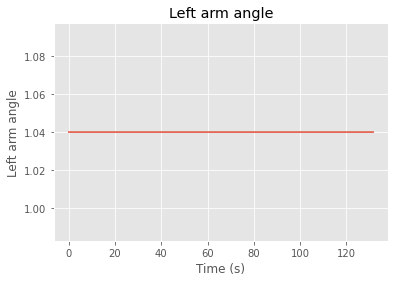

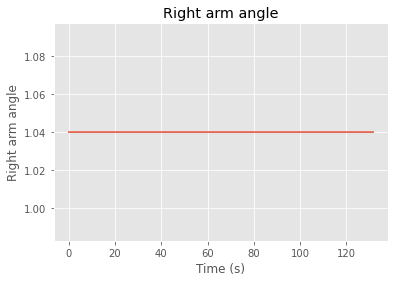

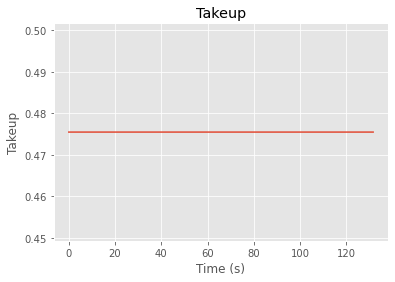

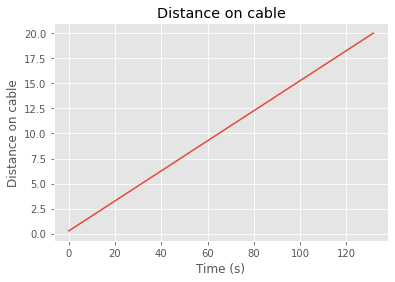

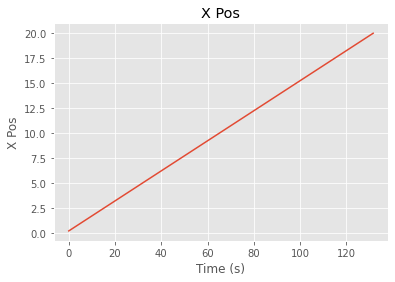

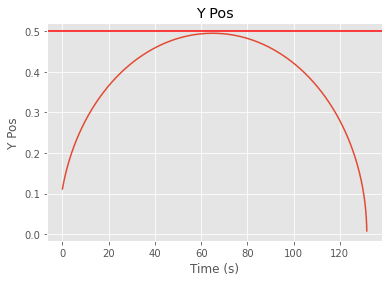

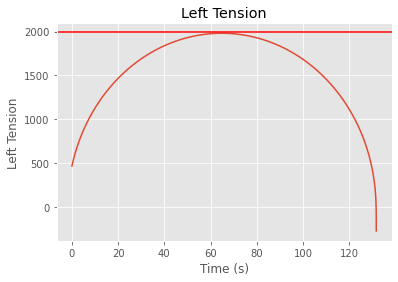

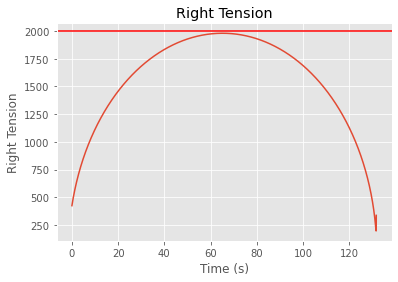

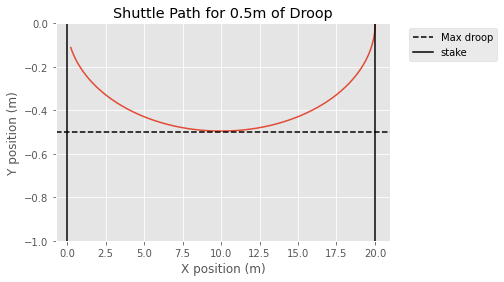

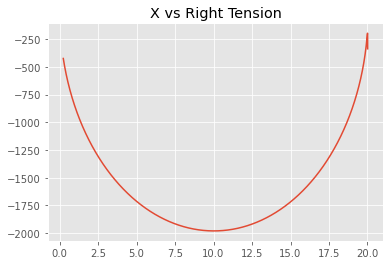

In [19]:

takeup_params = f"NEW {lencable}m of cable across {cablespan}m stakes with {mintakeup:.3f}m Takeup and {single_arm * 180 / math.pi:.3f} max angle"
if not os.path.exists(f"{directory}/{takeup_params}"):
    os.mkdir(f"{directory}/{takeup_params}")
var_list = ["Left arm angle", "Right arm angle", "Takeup", "Distance on cable", "X Pos", "Y Pos", "Left Tension", "Right Tension"]
for state in range(output.shape[1]):
    plt.figure()
    plt.plot(time, output[:, state])
    plt.title(var_list[state])
    plt.xlabel("Time (s)")
    plt.ylabel(f"{var_list[state]}")
    
    if var_list[state] == "Y Pos":
        plt.axhline(y=0.5, color = "r")
    elif "Tension" in var_list[state]:
        plt.axhline(y=2000, color = "r")
    
    plt.savefig(f"{directory}/{takeup_params}/{var_list[state]} over time for {mintakeup}m takeup across {cablespan}m stakes.png")
plt.figure()
plt.plot(output[:, 4], -1 * output[:, 5])
plt.title(f"Shuttle Path for {miny}m of Droop")
plt.ylim([-1, 0])
plt.axhline(y = -0.5, color = 'k', linestyle = '--', label="Max droop")
plt.axvline(x = 0, color = 'k', label="stake")
plt.axvline(x = cablespan, color = 'k')
plt.xlabel("X position (m)")
plt.ylabel(f"Y position (m)")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig(f"{directory}/{takeup_params}/path for {mintakeup}m takeup across {cablespan}m stakes.png", bbox_inches='tight')
plt.figure()
plt.plot(output[:, 4], -1 * output[:, 7])
plt.title("X vs Right Tension")

Text(0.5, 0, 'X position')

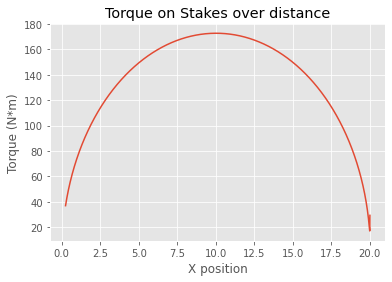

In [20]:
plt.plot(output[:, 4], 2 * output[:, 7] * math.sin(math.radians(5)/2))
plt.title("Torque on Stakes over distance")
plt.ylabel("Torque (N*m)")
plt.xlabel("X position")

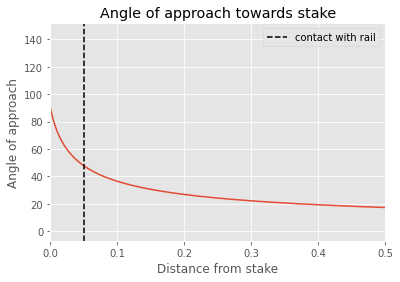

In [37]:
#plt.figure(figsize=(10, 10))
plt.plot(cablespan - output[:, 4], np.arctan2(output[:, 5], cablespan - output[:, 4]) * 180/math.pi)
#plt.xticks(np.arange(0, 1, .01))

plt.xlim(0, .5)
plt.axvline(x = 0.05, color = 'k', linestyle="--", label="contact with rail")
plt.xlabel("Distance from stake")
plt.ylabel("Angle of approach")
plt.title("Angle of approach towards stake")
plt.legend()
plt.savefig("Angleof approach.png")
plt.show()

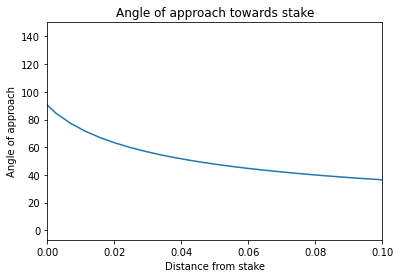

In [25]:
#plt.figure(figsize=(10, 10))
plt.plot(cablespan - output[:, 4], np.arctan2(output[:, 5], cablespan - output[:, 4]) * 180/math.pi)
#plt.xticks(np.arange(0, 1, .01))
plt.xlim(0, .1)
plt.xlabel("Distance from stake")
plt.ylabel("Angle of approach")
plt.title("Angle of approach towards stake")
plt.show()

## Sim Statistics

In [26]:
max(output[:, 5])

0.48636372662101957

In [27]:
min(output[:, 5])

0.008205595155382125

## Path GIF

MovieWriter ffmpeg unavailable; using Pillow instead.


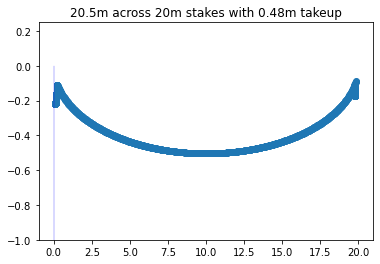

In [18]:
from matplotlib.animation import FuncAnimation
fig = plt.figure()
plt.xlim(-1, cablespan + 1)
plt.ylim(-1, 0.25)
graph, = plt.plot([], [], 'o')
plt.axvline(x = 0, color = 'b', lw = 0.3, ymax = 0.8)
plt.axvline(x = 25, color = 'b', lw=0.3,  ymax = 0.8)
plt.title(f"{lencable}m across {cablespan}m stakes with {mintakeup:.2f}m takeup")
def animate(i):
    graph.set_data(output[:i*5, 4], -output[:i*5, 5])
    return graph

ani = FuncAnimation(fig, animate, frames=int(len(output)) // 5, interval=20)
ani.save("constanttensioiningtest.gif", fps=60)
plt.show()